In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from data.data_utils import get_dataloaders
from models.mlp import MLP
from models.unet import UNet
from utils.sde import VESDE
from utils.train_utils import EMA, WarmUpScheduler, save_model, get_score_fn, eval_callback
from utils.sampling_utils import generation_callback
from torch.distributions import Uniform

class Args:
    base_log_dir = "./results"
    experiment = "deep_sphere_2"
    batch_size = 64
    dataset = 'sphere'
    data_samples = 10000
    n_spheres = 1
    ambient_dim = 2
    manifold_dim = 1
    noise_std = 0.0
    embedding_type = 'random_isometry'
    radii = []
    angle_std = -1
    network = 'MLP'  # or 'U-NET'
    hidden_dim = 512
    depth = 5
    dropout = 0.0
    learning_rate = 0.0001
    epochs = 100
    checkpoint_frequency = 20
    patience_epochs = 25
    device = 'cpu'  # or 'cuda' if torch.cuda.is_available()
    eval_callback_epochs = 20
    num_eval_points = 10
    eval_save_path = "./eval"
    vis_frequency = 50
    steps = 1024
    num_samples = 500

args = Args()

tensorboard_dir = os.path.join(args.base_log_dir, args.experiment, 'training_logs')
checkpoint_dir = os.path.join(args.base_log_dir, args.experiment, 'checkpoints')
eval_dir = os.path.join(args.base_log_dir, args.experiment, 'eval')
os.makedirs(tensorboard_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(eval_dir, exist_ok=True)

def get_DSM_loss_fn(sde, likelihood_weighting):
    def loss_fn(score_fn, batch, t_dist):
        x = batch
        t = t_dist.sample((x.shape[0],)).type_as(x)
        n = torch.randn_like(x)
        mean, std = sde.marginal_prob(x, t)
        perturbed_x = mean + std[(...,) + (None,) * len(x.shape[1:])] * n
        
        score = score_fn(perturbed_x, t)
        grad_log_pert_kernel = -1 * n / std[(...,) + (None,) * len(x.shape[1:])]
        losses = torch.square(score - grad_log_pert_kernel)
              
        if likelihood_weighting:
          _, g = sde.sde(torch.zeros_like(x), t, True)
          w2 = g ** 2
        else:
          w2 = std ** 2
              
        importance_weight = torch.exp(-1*t_dist.log_prob(t).type_as(t))
        losses = torch.sum(losses.reshape(losses.shape[0], -1), dim=-1) * w2 * importance_weight
        losses *= 1/2
        loss = torch.mean(losses)
        return loss
    return loss_fn

def print_model_size(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total number of parameters: {total_params}')

def train(args):
    writer = SummaryWriter(log_dir=tensorboard_dir)
    device = torch.device(args.device)

    train_loader, val_loader, test_loader = get_dataloaders(args)

    if args.network == 'MLP':
        model = MLP(args).to(device)
    elif args.network == 'U-NET':
        model = UNet(args).to(device)

    print_model_size(model)  # Print the size of the model

    sde = VESDE()
    sde.sampling_eps = 1e-5
    ema_model = EMA(model=model, decay=0.999)

    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
    scheduler = WarmUpScheduler(optimizer, args.learning_rate, warmup_steps=1000)

    step = 0
    best_checkpoints = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    t_dist = Uniform(sde.sampling_eps, 1)
    loss_fn = get_DSM_loss_fn(sde, likelihood_weighting=False)

    for epoch in range(args.epochs):
        model.train()
        train_loss = 0
        for data in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{args.epochs}"):
            optimizer.zero_grad()
            x = data[0].to(device)

            score_fn = get_score_fn(sde, model)
            loss = loss_fn(score_fn, x, t_dist)

            loss.backward()
            optimizer.step()
            ema_model.update()
            scheduler.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        writer.add_scalar('Loss/Train', train_loss, epoch)

        ema_model.apply_shadow()
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{args.epochs}"):
                x = data[0].to(device)

                score_fn = get_score_fn(sde, model)
                loss = loss_fn(score_fn, x, t_dist)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        writer.add_scalar('Loss/Validation', val_loss, epoch)

        if (epoch + 1) % args.vis_frequency == 0:
            steps = args.steps
            num_samples = args.num_samples
            shape = (num_samples, args.ambient_dim)
            generation_callback(writer, sde, model, steps, shape, device, epoch)
            
        ema_model.restore()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= args.patience_epochs:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        if (epoch + 1) % args.checkpoint_frequency == 0:
            save_model(model, ema_model, epoch, val_loss, "Model", checkpoint_dir, best_checkpoints)

    writer.close()
    return model, ema_model, sde, val_loader, best_checkpoints

model, ema_model, sde, val_loader, best_checkpoints = train(args)


/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-26 15:53:13.789194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Total number of parameters: 1316354


Validation Epoch 80/100: 100%|██████████| 16/16 [00:00<00:00, 290.61it/s]


Model model saved at './results/deep_sphere_2/checkpoints/Model_epoch_79_loss_0.313.pth'
Model EMA model saved at './results/deep_sphere_2/checkpoints/Model_epoch_79_loss_0.313_EMA.pth'


Validation Epoch 93/100: 100%|██████████| 16/16 [00:00<00:00, 292.91it/s]

Early stopping at epoch 93


In [2]:
import torch
import argparse
import os
import glob

from data.data_utils import get_dataloaders
from models.mlp import MLP
from models.unet import UNet
from utils.sde import VESDE
from utils.train_utils import EMA, load_model, eval_callback
from utils.sampling_utils import get_score_fn

# Load the best checkpoint
best_checkpoint_path = min([(checkpoint[1], checkpoint[2]) for checkpoint in best_checkpoints], key=lambda x: x[1])[0]
load_model(model, ema_model, best_checkpoint_path, "Model", is_ema=True)

# Apply EMA weights to the model
ema_model.apply_shadow()

# Set the model to evaluation mode
model.eval()

# Run evaluation callback
score_fn = get_score_fn(sde, model)  # Use the model with EMA weights applied
eval_callback(score_fn, sde, val_loader, args.num_eval_points, args.device, args.eval_save_path)


Model EMA model loaded from './results/deep_sphere_2/checkpoints/Model_epoch_79_loss_0.313_EMA.pth', Epoch: 79, Loss: 0.31349304132163525


100%|██████████| 10/10 [00:00<00:00, 80.62it/s]

1
Repeated x shape: torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64])
Score shape: torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64])
Score shape: torch.Size([64, 2])
torch.Size([64, 2])
Flattened scores shape: torch.Size([128, 2])
Singular values shape: torch.Size([2])
Repeated x shape: torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64])
Score shape: torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64])
Score shape: torch.Size([64, 2])
torch.Size([64, 2])
Flattened scores shape: torch.Size([128, 2])
Singular values shape: torch.Size([2])
Repeated x shape: torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64])
Score shape: torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64])
Score shape: torch.Size([64, 2])
torch.Size([64, 2])
Flattened scores shape: torch.Size([128, 2])
Singular values shape: torch.Size([2])
Repeated x shape: torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64])
Score shape: torch.Size([64, 2])
torch.Size([64, 2]) torch.Size([64])
Score s

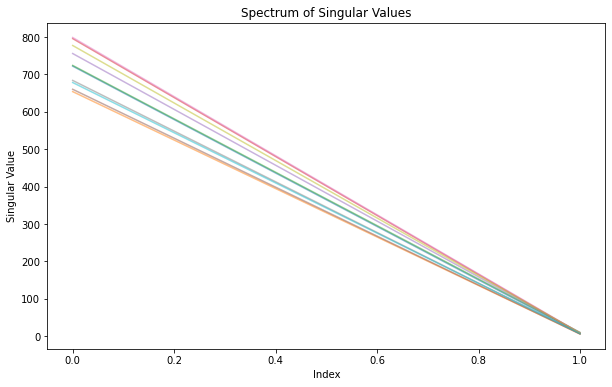

: 

In [5]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pickle
import os

# Evaluation and plotting
eval_dir = os.path.join(args.base_log_dir, args.experiment, 'eval')
singular_values_files = [os.path.join(eval_dir, f) for f in os.listdir(eval_dir) if f.endswith('.pkl')]

plt.figure(figsize=(10, 6))
for file in singular_values_files:
    with open(file, 'rb') as f:
        data = pickle.load(f)
        singular_values = data['singular_values']
        for sv in singular_values:
            plt.plot(sv, alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Spectrum of Singular Values')
plt.show()
